# Reconhecimento de Imagens com Deep Learning usando TensorFlow e keras

## Pipeline do Projeto

1. Importação das bibliotecas

2. Carregamento e visualização do dataset

3. Pré-processamento das imagens

4. Criação do modelo CNN simples

5. Treinamento e validação do modelo

6. Análise de desempenho

7. (Próximos notebooks) Ajustes para correção de overfitting e uso de MobileNet

# 0 Importação das bibliotecas

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from datetime import datetime
import seaborn as sns
import joblib
import random

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Input

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss, accuracy_score

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 Definição dos parâmetros

In [4]:
# define a largura e altua para redimensionar as imagens
image_width = 160
image_height = 160

In [5]:
# definir as imagens em 3 canais e cor : Vermelho, Verde e Azul (RGB)
image_color_channel = 3

In [6]:
# definir o valor máximo que um pixel pode ter em cada canal de cor (R, G ou B)
# normalizando os valores de pixel entre 0 e 1 (por exemplo, dividindo por 255)
image_color_channel_size = 255

In [7]:
# cria uma tupla com o tamanho da imagem (160, 160), últil para funções como `tf.image.resize()`.
image_size = (image_width, image_height)

In [8]:
# Cria a forma final da imagem: (160, 160, 3)
# Essa é a entrada padrão de uma rede neural convolucional (CNN)
image_shape = image_size + (image_color_channel,)

In [9]:
batch_size = 32
base_dir = './datasets/Plastic_Classification/'

##  Carregamento e visualização do dataset


In [10]:
# Carregar conjunto de treino com labels categóricos (one-hot)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Obter nomes das classes
class_names = train_ds_raw.class_names

# Aplicar prefetch
# Aplicar prefetch para desempenho
train_ds = train_ds_raw.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Teste
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False # Excelente manter shuffle=False no teste, pois precisaremos da ordem para calcular métricas e exibir previsões reais vs. preditas.
).prefetch(buffer_size=tf.data.AUTOTUNE)



Found 1441 files belonging to 7 classes.
Found 416 files belonging to 7 classes.
Found 209 files belonging to 7 classes.


In [11]:
def plot_sample_images(dataset, class_names, n=9):
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(n):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_idx = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.suptitle("Exemplos de imagens do conjunto de treino", fontsize=14)
    plt.tight_layout()
    plt.show()


In [13]:
for images, labels in train_ds.take(1):
    print("Formato das imagens:", images.shape)
    print("Rótulos:", labels.numpy())

Formato das imagens: (32, 160, 160, 3)
Rótulos: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [14]:
for images, labels in train_ds.take(1):
    label_indices = tf.argmax(labels, axis=1).numpy()
    class_labels = [class_names[i] for i in label_indices]
    print("Rótulos decodificados:", class_labels)


Rótulos decodificados: ['PET', 'PET', 'PET', 'PET', 'PET', 'PS', 'PS', 'LDPA', 'PP', 'HDPE', 'Other', 'LDPA', 'PET', 'PP', 'PET', 'HDPE', 'Other', 'PVC', 'PET', 'PVC', 'PP', 'PET', 'PVC', 'LDPA', 'PP', 'PVC', 'PP', 'HDPE', 'LDPA', 'PET', 'PP', 'PVC']


## Construir modelo CNN simples

In [15]:


model = models.Sequential([
    Input(shape=image_shape),  # Agora é o primeiro bloco
    layers.Rescaling(1./image_color_channel_size),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


| Camada               | Saída esperada | Observação                         |
| -------------------- | -------------- | ---------------------------------- |
| Input + Rescaling    | (160, 160, 3)  | Normaliza os valores de pixel      |
| Conv2D (32 filtros)  | (158, 158, 32) | Filtros pequenos, extração inicial |
| MaxPooling2D         | (79, 79, 32)   | Reduz dimensionalidade             |
| Conv2D (64 filtros)  | (77, 77, 64)   | Mais filtros                       |
| MaxPooling2D         | (38, 38, 64)   | Reduz novamente                    |
| Conv2D (128 filtros) | (36, 36, 128)  | Mais profundidade                  |
| MaxPooling2D         | (18, 18, 128)  | Redução final                      |
| Flatten              | (41472,)       | Prepara para a densa               |
| Dense (128)          | (128,)         | Camada oculta                      |
| Dropout (0.5)        | (128,)         | Evita overfitting                  |
| Dense (N\_classes)   | (N\_classes,)  | Saída com softmax                  |


In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 158, 158, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 79, 79, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 77, 77, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,402,695 (20.61 MB)

 Trainable params: 5,402,695 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

## Treinamento do modelo

In [19]:
# Tempo de treino
start_time = time.time()

# Treinamento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

train_time = time.time() - start_time
print(f"Tempo total de treinamento: {train_time:.2f} segundos")




# Definir callbacks
callbacks = [early_stop]

# Início do treinamento
start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Tempo de treinamento
training_time = time.time() - start_time
print(f"\n Tempo de treinamento: {training_time:.2f} segundos")


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.1981 - loss: 2.0465 - val_accuracy: 0.2332 - val_loss: 1.8295
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.2597 - loss: 1.8313 - val_accuracy: 0.2909 - val_loss: 1.7806
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.3059 - loss: 1.7534 - val_accuracy: 0.2957 - val_loss: 1.8754
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.3867 - loss: 1.6638 - val_accuracy: 0.3462 - val_loss: 1.6938
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.4837 - loss: 1.4097 - val_accuracy: 0.3870 - val_loss: 1.6132
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.5231 - loss: 1.2990 - val_accuracy: 0.4087 - val_loss: 1.6848
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.5704 - loss: 1.1503 - val_accuracy: 0.4159 - val_loss: 1.7616
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.5462 - loss: 1.2511 - val_accuracy: 0.4038 - v

## Visualizar desempenho

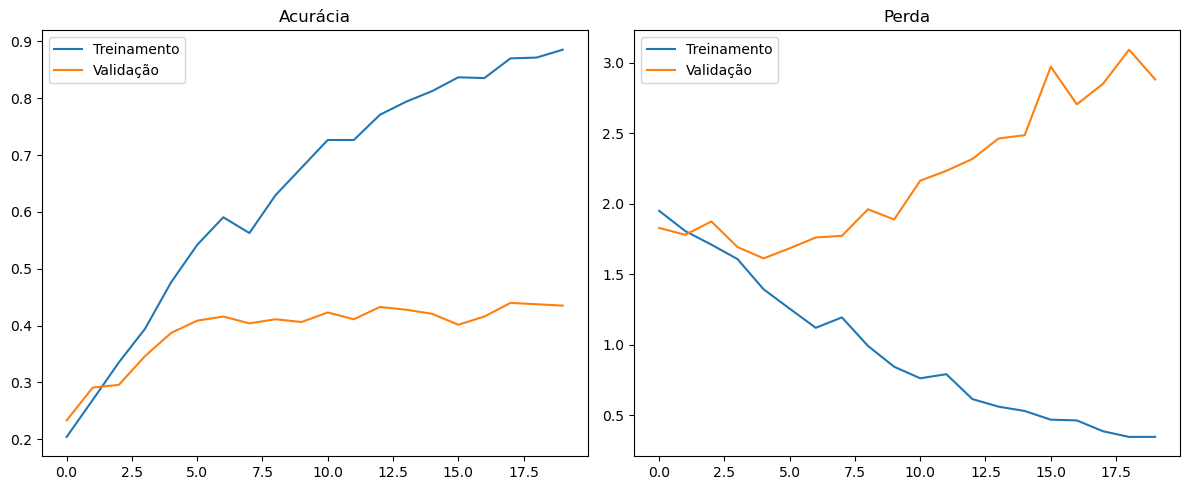

In [20]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Treinamento')
    plt.plot(epochs_range, val_acc, label='Validação')
    plt.title('Acurácia')
    plt.legend()

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Treinamento')
    plt.plot(epochs_range, val_loss, label='Validação')
    plt.title('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)



## Avaliar modelo no conjunto de teste

In [21]:
# Obter previsões do modelo
y_true = []
y_pred = []
start = time.time()

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

end = time.time()
inference_time = (end - start) / len(y_true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


In [ ]:
# Matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [22]:
# Métricas principais
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
logloss = log_loss(y_true, tf.keras.utils.to_categorical(y_pred, num_classes=len(class_names)))

print(f"Acurácia: {acc:.4f}")
print(f"F1-score (ponderado): {f1:.4f}")
print(f"Log loss: {logloss:.4f}")
print(f"Tempo de inferência por imagem: {inference_time*1000:.2f} ms")


Acurácia: 0.3493
F1-score (ponderado): 0.3124
Log loss: 23.4542
Tempo de inferência por imagem: 21.87 ms


## Matriz de confusão

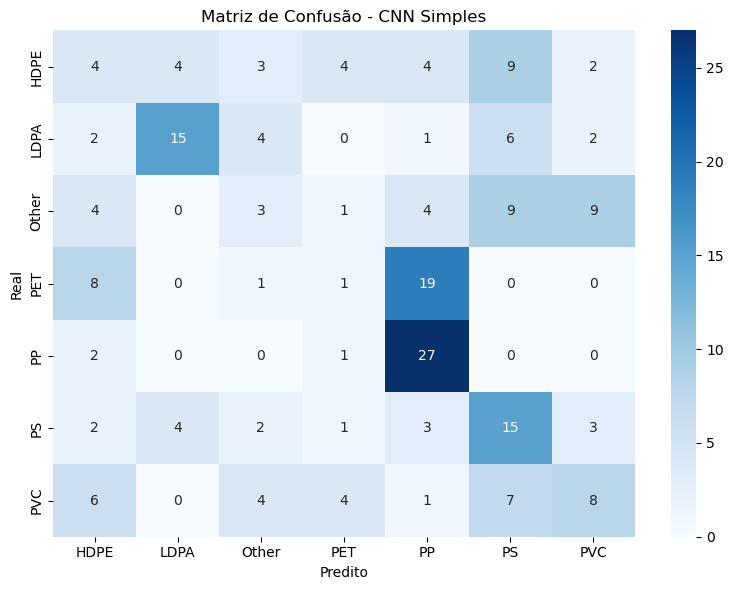

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão - CNN Simples')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()


## Relatório de classificação

In [24]:
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names))


Relatório de Classificação:
              precision    recall  f1-score   support

        HDPE       0.14      0.13      0.14        30
        LDPA       0.65      0.50      0.57        30
       Other       0.18      0.10      0.13        30
         PET       0.08      0.03      0.05        29
          PP       0.46      0.90      0.61        30
          PS       0.33      0.50      0.39        30
         PVC       0.33      0.27      0.30        30

    accuracy                           0.35       209
   macro avg       0.31      0.35      0.31       209
weighted avg       0.31      0.35      0.31       209



| Métrica            | Valor             |
| ------------------ | ----------------- |
| **Acurácia**       | \~0.35 (35%)      |
| **F1-Score Médio** | \~0.31            |
| **Melhor classe**  | `PP` (F1 = 0.61)  |
| **Pior classe**    | `PET` (F1 = 0.05) |

**O modelo teve bom desempenho em "PP" e LDPA, mas foi fraco em PET, Other e HDPE.**

- A acurácia de 35% é melhor do que o acaso (acerto aleatório = ~14%, já que são 7 classes).

- O modelo está tendendo a algumas classes mais frequentes ou fáceis de reconhecer (como PP e LDPA), o que pode ser indício de:

- Desequilíbrio entre as classes.

- Características visuais semelhantes entre classes.

- Capacidade limitada da arquitetura atual para capturar padrões mais sutis.



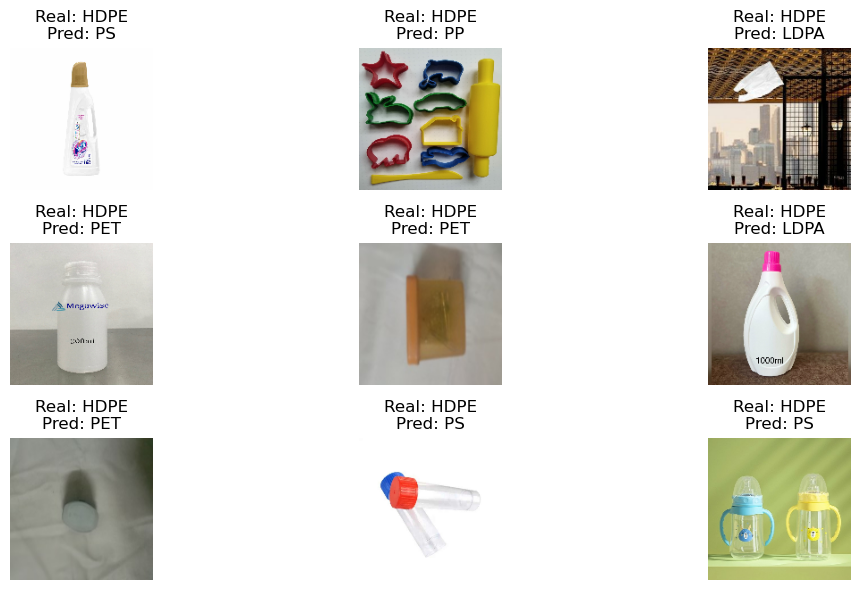

In [25]:
def plot_errors(dataset, y_true, y_pred, class_names, n_images=9):
    import random
    wrong = [(img, t, p) for img_batch, label_batch in dataset for img, t, p in zip(img_batch, y_true, y_pred) if t != p]
    sample = random.sample(wrong, min(n_images, len(wrong)))

    plt.figure(figsize=(12, 6))
    for i, (img, t, p) in enumerate(sample):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(f'Real: {class_names[t]}\nPred: {class_names[p]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_errors(test_ds, y_true, y_pred, class_names)


 ## Curva ROC multiclasse

In [28]:


# Extrair rótulos verdadeiros e probabilidades previstas
y_true = []
y_pred_proba = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))               # rótulos reais (inteiros)
    y_pred_proba.extend(model.predict(images))                     # probabilidades previstas

y_test_cnn = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


In [29]:
# Binarizar os rótulos reais para ROC
y_test_bin = label_binarize(y_test_cnn, classes=range(len(class_names)))


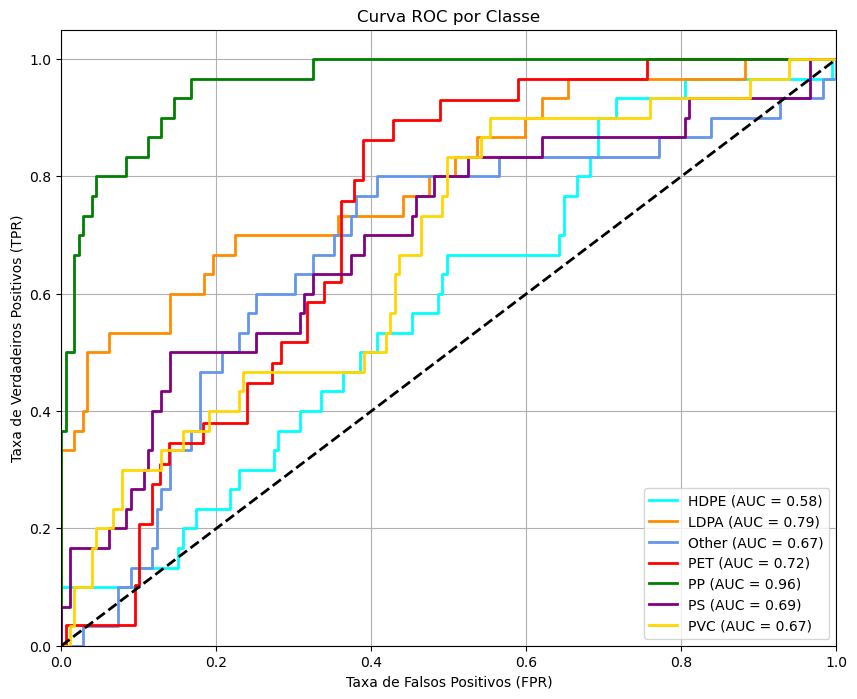

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Calcular FPR, TPR e AUC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar as curvas ROC
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'gold'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC por Classe')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [32]:


# 🔸 Criar pasta para salvar se não existir
save_dir = "models/05_cnn"
os.makedirs(save_dir, exist_ok=True)

# 🔸 Calcular métricas principais
f1 = f1_score(y_test_cnn, np.argmax(y_pred_proba, axis=1), average='weighted')
acc = accuracy_score(y_test_cnn, np.argmax(y_pred_proba, axis=1))
logloss = log_loss(y_test_cnn, y_pred_proba)

# 🔸 Tempo e nome do experimento
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
experiment_name = f"cnn_plastic_{timestamp}"

# 🔸 Dicionário de métricas
metrics = {
    "experiment": experiment_name,
    "model_type": "CNN_simples",
    "accuracy": round(acc, 4),
    "f1_score_weighted": round(f1, 4),
    "log_loss": round(logloss, 4),
    "num_classes": len(class_names),
    "class_names": class_names,
    "datetime": timestamp
}

# 🔸 Salvar métricas em JSON
metrics_path = os.path.join(save_dir, f"{experiment_name}_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)
print(f"Métricas salvas em: {metrics_path}")

# 🔸 Salvar o modelo
model_path = os.path.join(save_dir, f"{experiment_name}.keras")
model.save(model_path)
print(f"Modelo salvo em: {model_path}")


Métricas salvas em: models/05_cnn\cnn_plastic_2025-07-20_00-52-44_metrics.json
Modelo salvo em: models/05_cnn\cnn_plastic_2025-07-20_00-52-44.keras


# Analise 

### Análise por partes:
#### ✅ Pontos positivos
    - A acurácia de treinamento evoluiu bem: de 17% → 64%.

    - O loss de treino caiu significativamente: de 2.12 → 1.00.

    - O modelo está aprendendo algo, não é aleatório.

#### ⚠️ Pontos de atenção
    - A acurácia de validação estagnou entre ~38% e 41%, sem acompanhar o ganho no treino.

    - O loss de validação aumentou após a 6ª época → overfitting detectado.

    - Generalização ruim: o modelo aprendeu os dados de treino, mas não consegue aplicar bem em dados não vistos.

#### 🧠 Conclusão
Seu modelo CNN simples está overfittando: aprende muito bem o treino, mas não transfere esse aprendizado para a validação.

### 🛠️ Próximos passos recomendados

1. Reduza o overfitting com:

    - Dropout entre as camadas densas (ex: Dropout(0.5))

    - Data augmentation com ImageDataGenerator ou layers.RandomFlip/Rotation/etc

    - EarlyStopping no ModelCheckpoint

2. Aumente a capacidade do modelo de forma controlada:

    - Adicionar mais filtros (ex: 64 → 128)

    - Mais camadas convolucionais com BatchNormalization

3. Ajuste hiperparâmetros:

    - Aprendizado: use ReduceLROnPlateau

    - Batch size menor (ex: 16)

    - Mais épocas (com early stopping)

4. Experimente transferência de aprendizado:

     - Use um modelo pré-treinado como MobileNetV2 ou ResNet50 com include_top=False

